In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import pickle

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")


In [6]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df = pd.read_csv("/content/NetflixSimple.csv")
df.head()


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


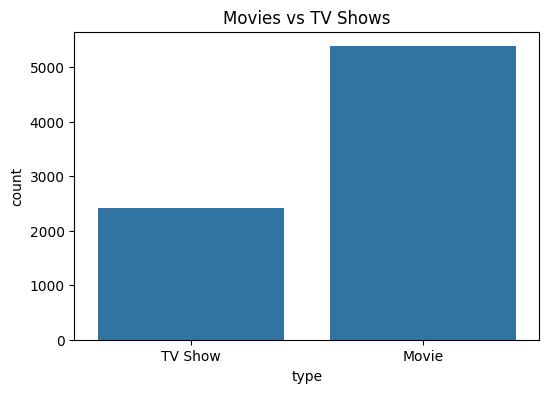

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(x='type', data=df)
plt.title("Movies vs TV Shows")
plt.show()


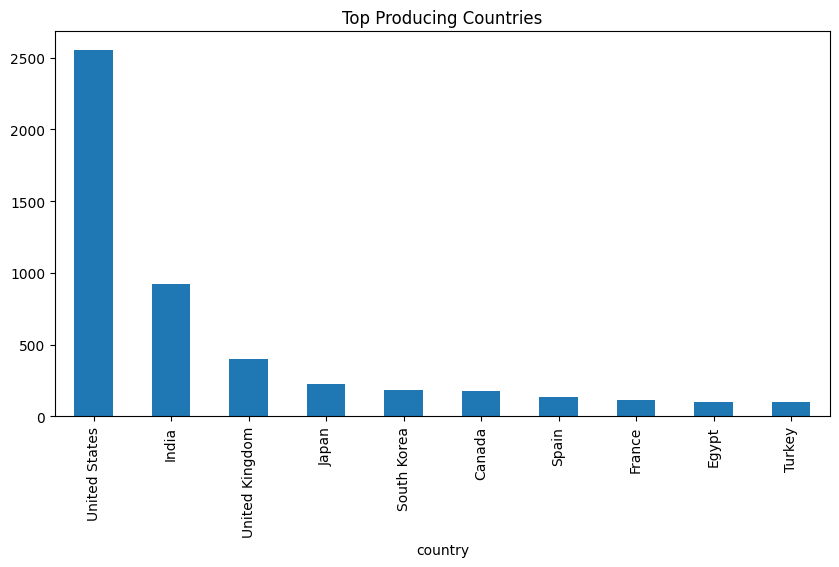

In [9]:
top_countries = df['country'].value_counts().head(10)

plt.figure(figsize=(10,5))
top_countries.plot(kind='bar')
plt.title("Top Producing Countries")
plt.show()


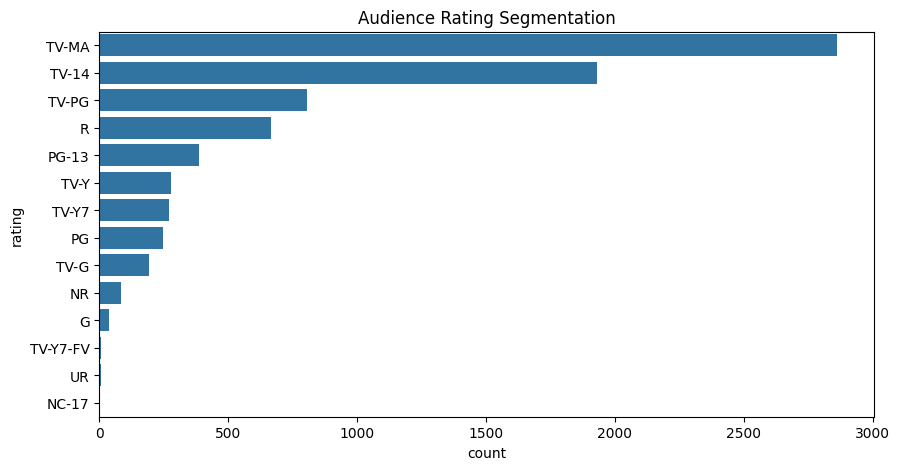

In [10]:
plt.figure(figsize=(10,5))
sns.countplot(y='rating', data=df,
              order=df['rating'].value_counts().index)
plt.title("Audience Rating Segmentation")
plt.show()


In [11]:
text_cols = ['director', 'cast', 'country',
             'description', 'listed_in']

for col in text_cols:
    df[col] = df[col].fillna("Unknown")


In [12]:
df['bag_of_content'] = (
      df['type'] + " " +
      df['listed_in'] + " " +
      df['director'] + " " +
      df['cast'] + " " +
      df['country'] + " " +
      df['description']
)

df[['title','bag_of_content']].head()


,title,bag_of_content
0,3%,"TV Show International TV Shows, TV Dramas, TV ..."
1,7:19,"Movie Dramas, International Movies Jorge Miche..."
2,23:59,"Movie Horror Movies, International Movies Gilb..."
3,9,"Movie Action & Adventure, Independent Movies, ..."
4,21,"Movie Dramas Robert Luketic Jim Sturgess, Kevi..."


In [13]:
def clean_text(text):

    text = text.lower()
    text = re.sub(r'[^a-zA-Z ]', '', text)

    words = text.split()
    words = [w for w in words if w not in stop_words]

    return " ".join(words)

df['clean_text'] = df['bag_of_content'].apply(clean_text)


In [14]:
tfidf = TfidfVectorizer(max_features=5000)

X = tfidf.fit_transform(df['clean_text'])

print("TF-IDF Shape:", X.shape)


TF-IDF Shape: (7787, 5000)


In [15]:
svd = TruncatedSVD(n_components=100, random_state=42)

X_reduced = svd.fit_transform(X)

print("Reduced Shape:", X_reduced.shape)


Reduced Shape: (7787, 100)


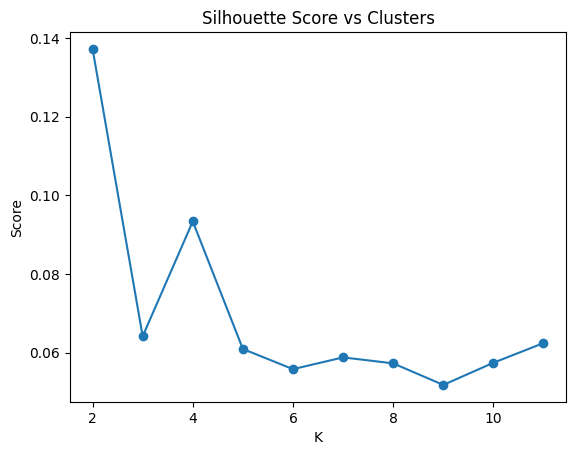

In [16]:
scores = []
K_range = range(2, 12)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_reduced)
    score = silhouette_score(X_reduced, labels)
    scores.append(score)

plt.plot(K_range, scores, marker='o')
plt.title("Silhouette Score vs Clusters")
plt.xlabel("K")
plt.ylabel("Score")
plt.show()


In [17]:
kmeans = KMeans(n_clusters=8, random_state=42)

df['cluster'] = kmeans.fit_predict(X_reduced)

df[['title','cluster']].head()


,title,cluster
0,3%,4
1,7:19,0
2,23:59,0
3,9,1
4,21,1


In [18]:
for i in range(8):
    print(f"\nCluster {i}:")
    print(df[df['cluster']==i]['title'].head(5).values)



Cluster 0:
['7:19' '23:59' '122' '2,215' 'Oct-01']

Cluster 1:
['9' '21' '187' '1922' '3022']

Cluster 2:
['100 Days My Prince' '12 Years Promise' '26 Years' '28 Moons'
 'A Korean Odyssey']

Cluster 3:
['14 Cameras' '48 Christmas Wishes' 'A 2nd Chance'
 "A Babysitter's Guide to Monster Hunting" 'A Champion Heart']

Cluster 4:
['3%' '46' '1983' '1994' 'Feb-09']

Cluster 5:
['\u200bSAINT SEIYA: Knights of the Zodiac' '#blackAF' '13 Reasons Why'
 '3Below: Tales of Arcadia' '44 Cats']

Cluster 6:
['706' '1920' '15-Aug' '\u200b\u200bKuch Bheege Alfaaz'
 '\u200bGoli Soda 2']

Cluster 7:
['(Un)Well' '100 Humans' '60 Days In' '7 Days Out' '72 Cutest Animals']


In [19]:
similarity_matrix = cosine_similarity(X_reduced)


In [20]:
indices = pd.Series(df.index,
                    index=df['title']).drop_duplicates()

def recommend(title, top_n=5):

    if title not in indices:
        return "Title not found"

    idx = indices[title]

    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores,
                        key=lambda x: x[1],
                        reverse=True)

    sim_scores = sim_scores[1:top_n+1]

    movie_indices = [i[0] for i in sim_scores]

    return df['title'].iloc[movie_indices]


In [21]:
recommend("3 Idiots")


,title
1758,Dil Dhadakne Do
7371,Upstarts
4485,No Entry
7223,Trimurti
6042,Thank You


In [22]:
pickle.dump(similarity_matrix,
            open("similarity.pkl","wb"))


In [23]:
files.download("similarity.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>